In [11]:
from qutree import *

def parabula(x):
    return np.sum(x**2)

def double_well_2(q):
    x = givens_x(-20.) @ givens_z(10.) @ givens_x(10.) @ q
    #x = q
    v1 = (x[0] - 0.02)**4 - 0.5 * x[0]**2
    v2 = (x[1] - 0.01)**4 - 0.5 * x[1]**2
    v3 = (x[2] - 0.05)**4 - 0.5 * x[2]**2
    return np.exp(-(v1 + v2 + v3))

def double_well(x):
    v1 = 0.5*(x[0]- 0.5)**2 + 0.25 * (x[0] + 0.5)**2
    v2 = 0.5*(x[1]- 0.5)**2 + 0.25 * (x[1] + 0.5)**2
    v3 = 0.5*(x[2]- 0.5)**2 + 0.25 * (x[2] + 0.5)**2
    return v1 + v2 + v3

def Err_xyz(x):
    return parabula(x)

def Err_spherical(q):
    x = spherical_to_xyz(q)
    return parabula(x)

N = 20
r = 3
f = 3

class Objective:
    def __init__(self, Err, linspace, q_to_xyz = lambda x : x):
        self.Err = Err
        self.q_to_xyz = q_to_xyz
        self.linspace = linspace

    def __call__(self, x):
        q = self.xyz_to_q(x)
        return self.Err(q)
    
    def plot(self, G):
        plot_tn_xyz(G, self.Err, self.q_to_xyz)

#O = Objective(Err_xyz, spherical_linspace(N, include_boundaries= False), spherical_to_xyz)
O = Objective(double_well_2, [linspace(-2., 2., N = N)] * f)
G = balanced_tree(f, r, N)
#G = tt_graph(f, r, N)
G = tn_grid(G, O.linspace)
O.plot(G)

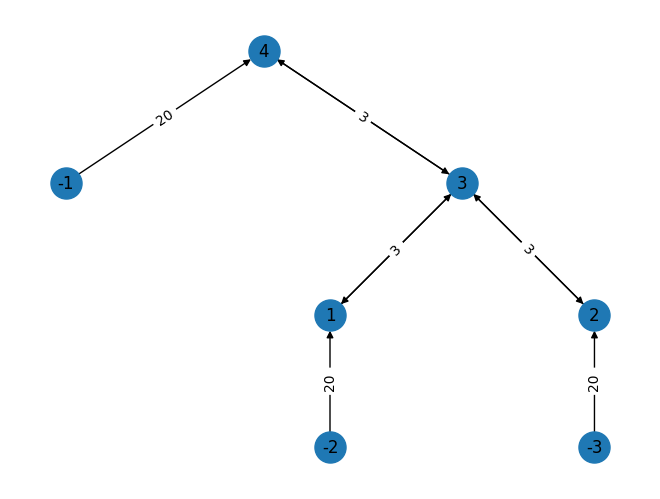

In [12]:

def ttnopt_step(G, O, dfs = []):
    G = G.copy()
    for edge in depth_first(G):
        if (is_leaf(edge)):
            continue
        
        pre = pre_edges(G, edge)
        pre = permute_to_back(pre, flip(edge))

        pre_grids = collect(G, pre, 'grid')
        next, mat = maxvol_grids(pre_grids, O.Err)
        G[edge[0]][edge[1]]['grid'] = next

        # update dfs
        build_node_grid(G)
        dfs.append(tngrid_to_df(G, O))
    return G, dfs

dfs = []
nsweep = 6
build_node_grid(G)
dfs.append(tngrid_to_df(G, O))
for sw in range(nsweep):
    G, dfs = ttnopt_step(G, O, dfs)
df = concat_pandas(dfs) # concat dfs

import plotly.express as px
fig = px.scatter_3d(df, x="x1", y="x2", z="x3", animation_frame="time", animation_group="index",
           size="size", color="f", hover_name="index",
           size_max=15,
            width=800, height=600)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 20
camera = dict(
    eye=dict(x=1.5, y=-1.0, z=1.2),  # Set the position of the camera
    center=dict(x=0, y=0, z=0),       # Set the point the camera is looking at
    up=dict(x=0, y=0, z=1)            # Set the upward direction of the camera
)
fig.update_layout(scene_camera=camera)
fig.write_html('ttnopt.html')
plot_tree(G)
fig

(14, 13) [(13, 14), (12, 14)]
(13, 9) [(9, 13), (8, 13), (14, 13)]
(9, 5) [(5, 9), (4, 9), (13, 9)]
(5, 9) [(-6, 5), (9, 5)]
(9, 4) [(5, 9), (4, 9), (13, 9)]
(4, 9) [(-5, 4), (9, 4)]
(9, 13) [(5, 9), (4, 9), (13, 9)]
(13, 8) [(9, 13), (8, 13), (14, 13)]
(8, 7) [(7, 8), (6, 8), (13, 8)]
(7, 8) [(-8, 7), (8, 7)]
(8, 6) [(7, 8), (6, 8), (13, 8)]
(6, 8) [(-7, 6), (8, 6)]
(8, 13) [(7, 8), (6, 8), (13, 8)]
(13, 14) [(9, 13), (8, 13), (14, 13)]
(14, 12) [(13, 14), (12, 14)]
(12, 11) [(11, 12), (10, 12), (14, 12)]
(11, 1) [(1, 11), (0, 11), (12, 11)]
(1, 11) [(-2, 1), (11, 1)]
(11, 0) [(1, 11), (0, 11), (12, 11)]
(0, 11) [(-1, 0), (11, 0)]
(11, 12) [(1, 11), (0, 11), (12, 11)]
(12, 10) [(11, 12), (10, 12), (14, 12)]
(10, 3) [(3, 10), (2, 10), (12, 10)]
(3, 10) [(-4, 3), (10, 3)]
(10, 2) [(3, 10), (2, 10), (12, 10)]
(2, 10) [(-3, 2), (10, 2)]
(10, 12) [(3, 10), (2, 10), (12, 10)]
(12, 14) [(11, 12), (10, 12), (14, 12)]


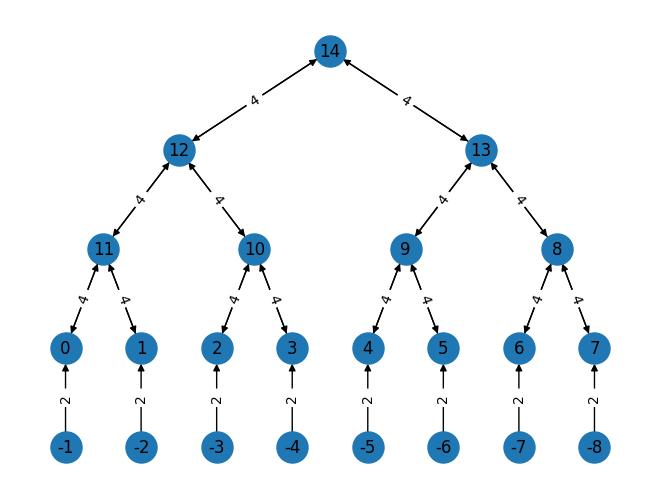

In [13]:
G = balanced_tree(8, 4, 2)
plot_tree(G)
#G = tt_graph(3, 5, N)
#plot_tt_diagram(G)

for edge in depth_first(G):
    if (is_leaf(edge)):
        continue
    pre = pre_edges(G, edge)
    print(edge, pre)

In [14]:
# Original and sorted lists of edges
edges = [(11, 12), (10, 12), (14, 12)]
expected = [(10, 12), (14, 12), (11, 12)]

p = back_permutation(edges, (11, 12))

A = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
print(A.transpose(p))

[[[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[4 4 4]
  [5 5 5]
  [6 6 6]]

 [[7 7 7]
  [8 8 8]
  [9 9 9]]]


In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_boston, load_wine
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import plotly.graph_objects as go

boston_df = load_boston()

%matplotlib inline
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT',]

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = boston_df['HousePrice'],
                   colorscale = px.colors.sequential.Blues,
                   cmin=25, cmax=50),
        dimensions = [dict(label=col, values=boston_df[col]) for col in cols]
    )
)

fig.update_layout(
    title="Boston House Price Coordinates Plot"
)

fig.show()

ModuleNotFoundError: No module named 'sklearn'